In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import time

## Data Collection
#### Dataset = https://www.kaggle.com/c/histopathologic-cancer-detection/data

In [2]:
original_dataset_path = '/datasets/histopathologic-cancer-detection/train'
csv_file_path = '/datasets/histopathologic-cancer-detection/train_labels.csv'

In [3]:
df = pd.read_csv(csv_file_path)
df.shape


(220025, 2)

In [4]:

df = df.rename(columns={df.columns[0]: 'filename', df.columns[1]: 'label'})

# === CLASS MAPPING ===
label_map = {
    0: 'benign',
    1: 'malignant'
}
# ======================
df['label'] = df['label'].map(label_map)
df['filename'] = df['filename'].astype(str) + '.tif'

### EDA

In [5]:
# Is there any missing values in the label column?
print(df['label'].isnull().sum())

0


In [6]:
print("Class distribution in original dataset:")
class_counts = df['label'].value_counts(normalize=True)
print(class_counts.apply(lambda x: f"{x:.2%}").to_dict())

Class distribution in original dataset:
{'benign': '59.50%', 'malignant': '40.50%'}


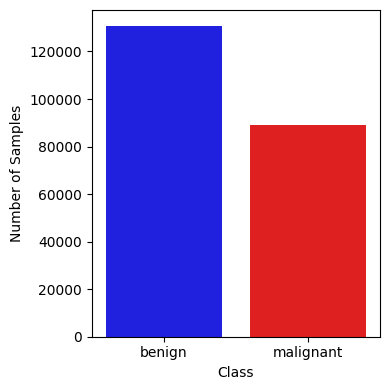

In [7]:
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='label', hue='label', palette=['blue', 'red'], legend=False)
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

### Data Spliting

In [8]:
# === SPLIT RATIOS ===
split_ratios = {
    'train': 0.7,
    'val': 0.15,
    'test': 0.15
}

train_df, temp_df = train_test_split(df, test_size=1 - split_ratios['train'], stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=split_ratios['test'] / (split_ratios['val'] + split_ratios['test']),
                                   stratify=temp_df['label'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

In [9]:

project_folder = './'
original_dataset_dir = os.path.join(project_folder, '..', original_dataset_path)
new_dataset_dir = os.path.join(project_folder, 'dataset')

# === CREATE NEW DIRECTORY STRUCTURE ===
for split_name in splits:
    for class_name in label_map.values():
        os.makedirs(os.path.join(new_dataset_dir, split_name, class_name), exist_ok=True)

# === COPY FILES ===
def copy_split_files(split_name, split_df):
    for _, row in split_df.iterrows():
        src_path = os.path.join(original_dataset_dir, row['filename'])
        dst_path = os.path.join(new_dataset_dir, split_name, row['label'], row['filename'])
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"[WARNING] File not found: {src_path}")

for split_name, split_df in splits.items():
    print(f"Copying {split_name} files...")
    copy_split_files(split_name, split_df)

print("All files copied and dataset split with original class balance.")


Copying train files...
Copying val files...
Copying test files...
All files copied and dataset split with original class balance.


## Data Preprocessing

### Data Transformation

In [10]:
# Image size
img_size = 96

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet stats
                         [0.229, 0.224, 0.225])
])


val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet stats
                         [0.229, 0.224, 0.225])
])


### Data Loading

In [11]:
# Batch size
batch_size = 32

# Paths
data_dir = './dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'val')
test_dir  = os.path.join(data_dir, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=4)

print(train_dataset.class_to_idx)  # {'benign': 0, 'malignant': 1}

{'benign': 0, 'malignant': 1}


## Model Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training function

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, model_name="model"):
    model = model.to(device)
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / len(dataloaders['train'])
        epoch_train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_running_loss / len(dataloaders['val'])
        epoch_val_acc = val_correct / val_total

        # ---- Logging ----
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        history.append({
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "train_acc": epoch_train_acc,
            "val_loss": epoch_val_loss,
            "val_acc": epoch_val_acc,
            'time_sec': round(time.time() - start_time, 2)
        })

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    # Save best model weights
    torch.save(best_model_wts, f"best_{model_name}.pth")
    print(f"Best model saved as best_{model_name}.pth with val acc: {best_val_acc:.4f}")

    # Save training history
    pd.DataFrame(history).to_csv(f"training_log_{model_name}.csv", index=False)

    # Return best model
    model.load_state_dict(best_model_wts)
    return model


### Train Models

In [14]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

num_epochs = 50

# === LOSS FUNCTION ===
# Class weights for imbalanced dataset
class_weights = torch.tensor([0.405, 0.595], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

In [15]:
# ResNet50 model
resnet50_model = models.resnet50(weights='DEFAULT')

resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 2)
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=1e-4)

resnet50_model = train_model(
    resnet50_model,
    {'train': train_loader, 'val': val_loader},
    criterion,
    optimizer,
    num_epochs,
    model_name='ResNet50'
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Yu K/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.5MB/s]
Epoch 1/50 - Training: 100%|██████████| 4814/4814 [04:50<00:00, 16.57it/s]


Epoch 1: Train Loss: 0.2207, Train Acc: 0.9142, Val Loss: 0.1312, Val Acc: 0.9518


Epoch 2/50 - Training: 100%|██████████| 4814/4814 [04:42<00:00, 17.04it/s]


Epoch 2: Train Loss: 0.1499, Train Acc: 0.9453, Val Loss: 0.1080, Val Acc: 0.9608


Epoch 3/50 - Training: 100%|██████████| 4814/4814 [04:28<00:00, 17.91it/s]


Epoch 3: Train Loss: 0.1272, Train Acc: 0.9543, Val Loss: 0.1031, Val Acc: 0.9637


Epoch 4/50 - Training: 100%|██████████| 4814/4814 [04:41<00:00, 17.13it/s]


Epoch 4: Train Loss: 0.1129, Train Acc: 0.9597, Val Loss: 0.1393, Val Acc: 0.9534


Epoch 5/50 - Training: 100%|██████████| 4814/4814 [04:46<00:00, 16.80it/s]


Epoch 5: Train Loss: 0.1036, Train Acc: 0.9633, Val Loss: 0.1118, Val Acc: 0.9628


Epoch 6/50 - Training: 100%|██████████| 4814/4814 [04:46<00:00, 16.82it/s]


Epoch 6: Train Loss: 0.0947, Train Acc: 0.9666, Val Loss: 0.0985, Val Acc: 0.9670


Epoch 7/50 - Training: 100%|██████████| 4814/4814 [04:56<00:00, 16.25it/s]


Epoch 7: Train Loss: 0.0889, Train Acc: 0.9685, Val Loss: 0.0892, Val Acc: 0.9704


Epoch 8/50 - Training: 100%|██████████| 4814/4814 [04:44<00:00, 16.91it/s]


Epoch 8: Train Loss: 0.0832, Train Acc: 0.9704, Val Loss: 0.1130, Val Acc: 0.9624


Epoch 9/50 - Training: 100%|██████████| 4814/4814 [04:51<00:00, 16.54it/s]


Epoch 9: Train Loss: 0.0782, Train Acc: 0.9724, Val Loss: 0.1084, Val Acc: 0.9671


Epoch 10/50 - Training: 100%|██████████| 4814/4814 [04:47<00:00, 16.76it/s]


Epoch 10: Train Loss: 0.0735, Train Acc: 0.9740, Val Loss: 0.1136, Val Acc: 0.9642


Epoch 11/50 - Training: 100%|██████████| 4814/4814 [04:41<00:00, 17.08it/s]


Epoch 11: Train Loss: 0.0692, Train Acc: 0.9756, Val Loss: 0.0900, Val Acc: 0.9701


Epoch 12/50 - Training: 100%|██████████| 4814/4814 [04:56<00:00, 16.23it/s]


Epoch 12: Train Loss: 0.0658, Train Acc: 0.9766, Val Loss: 0.1037, Val Acc: 0.9635


Epoch 13/50 - Training: 100%|██████████| 4814/4814 [04:38<00:00, 17.30it/s]


Epoch 13: Train Loss: 0.0621, Train Acc: 0.9778, Val Loss: 0.0848, Val Acc: 0.9713


Epoch 14/50 - Training: 100%|██████████| 4814/4814 [04:45<00:00, 16.85it/s]


Epoch 14: Train Loss: 0.0582, Train Acc: 0.9795, Val Loss: 0.0845, Val Acc: 0.9740


Epoch 15/50 - Training: 100%|██████████| 4814/4814 [28:48<00:00,  2.79it/s]     


Epoch 15: Train Loss: 0.0560, Train Acc: 0.9803, Val Loss: 0.0846, Val Acc: 0.9728


Epoch 16/50 - Training: 100%|██████████| 4814/4814 [04:52<00:00, 16.46it/s]


Epoch 16: Train Loss: 0.0538, Train Acc: 0.9811, Val Loss: 0.1002, Val Acc: 0.9672


Epoch 17/50 - Training: 100%|██████████| 4814/4814 [04:48<00:00, 16.67it/s]


Epoch 17: Train Loss: 0.0530, Train Acc: 0.9813, Val Loss: 0.1003, Val Acc: 0.9687


Epoch 18/50 - Training: 100%|██████████| 4814/4814 [04:42<00:00, 17.04it/s]


Epoch 18: Train Loss: 0.0488, Train Acc: 0.9822, Val Loss: 0.1033, Val Acc: 0.9668


Epoch 19/50 - Training: 100%|██████████| 4814/4814 [04:42<00:00, 17.06it/s]


Epoch 19: Train Loss: 0.0455, Train Acc: 0.9837, Val Loss: 0.1015, Val Acc: 0.9669


Epoch 20/50 - Training: 100%|██████████| 4814/4814 [04:50<00:00, 16.56it/s]


Epoch 20: Train Loss: 0.0443, Train Acc: 0.9844, Val Loss: 0.2936, Val Acc: 0.9325


Epoch 21/50 - Training: 100%|██████████| 4814/4814 [04:44<00:00, 16.93it/s]


Epoch 21: Train Loss: 0.0424, Train Acc: 0.9849, Val Loss: 0.0842, Val Acc: 0.9740


Epoch 22/50 - Training: 100%|██████████| 4814/4814 [04:47<00:00, 16.76it/s]


Epoch 22: Train Loss: 0.0414, Train Acc: 0.9852, Val Loss: 0.0863, Val Acc: 0.9734


Epoch 23/50 - Training: 100%|██████████| 4814/4814 [04:22<00:00, 18.35it/s]


Epoch 23: Train Loss: 0.0399, Train Acc: 0.9858, Val Loss: 0.0787, Val Acc: 0.9757


Epoch 24/50 - Training: 100%|██████████| 4814/4814 [04:04<00:00, 19.65it/s]


Epoch 24: Train Loss: 0.0384, Train Acc: 0.9865, Val Loss: 0.0992, Val Acc: 0.9695


Epoch 25/50 - Training: 100%|██████████| 4814/4814 [04:09<00:00, 19.33it/s]


Epoch 25: Train Loss: 0.0381, Train Acc: 0.9863, Val Loss: 0.1707, Val Acc: 0.9639


Epoch 26/50 - Training: 100%|██████████| 4814/4814 [04:00<00:00, 20.01it/s]


Epoch 26: Train Loss: 0.0363, Train Acc: 0.9871, Val Loss: 0.1089, Val Acc: 0.9659


Epoch 27/50 - Training: 100%|██████████| 4814/4814 [03:51<00:00, 20.77it/s]


Epoch 27: Train Loss: 0.0338, Train Acc: 0.9878, Val Loss: 0.0863, Val Acc: 0.9751


Epoch 28/50 - Training: 100%|██████████| 4814/4814 [03:59<00:00, 20.07it/s]


Epoch 28: Train Loss: 0.0338, Train Acc: 0.9879, Val Loss: 0.1442, Val Acc: 0.9624


Epoch 29/50 - Training: 100%|██████████| 4814/4814 [03:45<00:00, 21.35it/s]


Epoch 29: Train Loss: 0.0324, Train Acc: 0.9889, Val Loss: 0.0834, Val Acc: 0.9767


Epoch 30/50 - Training: 100%|██████████| 4814/4814 [04:05<00:00, 19.64it/s]


Epoch 30: Train Loss: 0.0305, Train Acc: 0.9890, Val Loss: 0.1057, Val Acc: 0.9685


Epoch 31/50 - Training: 100%|██████████| 4814/4814 [03:56<00:00, 20.39it/s]


Epoch 31: Train Loss: 0.0316, Train Acc: 0.9891, Val Loss: 0.1644, Val Acc: 0.9645


Epoch 32/50 - Training: 100%|██████████| 4814/4814 [04:03<00:00, 19.81it/s]


Epoch 32: Train Loss: 0.0295, Train Acc: 0.9897, Val Loss: 0.0980, Val Acc: 0.9714


Epoch 33/50 - Training: 100%|██████████| 4814/4814 [03:55<00:00, 20.48it/s]


Epoch 33: Train Loss: 0.0281, Train Acc: 0.9901, Val Loss: 0.1053, Val Acc: 0.9725


Epoch 34/50 - Training: 100%|██████████| 4814/4814 [03:48<00:00, 21.05it/s]


Epoch 34: Train Loss: 0.0278, Train Acc: 0.9901, Val Loss: 0.1918, Val Acc: 0.9746


Epoch 35/50 - Training: 100%|██████████| 4814/4814 [03:47<00:00, 21.20it/s]


Epoch 35: Train Loss: 0.0282, Train Acc: 0.9901, Val Loss: 0.0947, Val Acc: 0.9721


Epoch 36/50 - Training: 100%|██████████| 4814/4814 [03:58<00:00, 20.20it/s]


Epoch 36: Train Loss: 0.0279, Train Acc: 0.9904, Val Loss: 0.0843, Val Acc: 0.9773


Epoch 37/50 - Training: 100%|██████████| 4814/4814 [03:56<00:00, 20.36it/s]


Epoch 37: Train Loss: 0.0256, Train Acc: 0.9911, Val Loss: 0.0966, Val Acc: 0.9741


Epoch 38/50 - Training: 100%|██████████| 4814/4814 [03:57<00:00, 20.26it/s]


Epoch 38: Train Loss: 0.0247, Train Acc: 0.9913, Val Loss: 0.2514, Val Acc: 0.9419


Epoch 39/50 - Training: 100%|██████████| 4814/4814 [04:04<00:00, 19.69it/s]


Epoch 39: Train Loss: 0.0249, Train Acc: 0.9912, Val Loss: 0.0826, Val Acc: 0.9765


Epoch 40/50 - Training: 100%|██████████| 4814/4814 [03:58<00:00, 20.17it/s]


Epoch 40: Train Loss: 0.0232, Train Acc: 0.9921, Val Loss: 0.1116, Val Acc: 0.9691


Epoch 41/50 - Training: 100%|██████████| 4814/4814 [03:51<00:00, 20.82it/s]


Epoch 41: Train Loss: 0.0229, Train Acc: 0.9919, Val Loss: 0.0932, Val Acc: 0.9753


Epoch 42/50 - Training: 100%|██████████| 4814/4814 [04:05<00:00, 19.59it/s]


Epoch 42: Train Loss: 0.0234, Train Acc: 0.9920, Val Loss: 0.1198, Val Acc: 0.9714


Epoch 43/50 - Training: 100%|██████████| 4814/4814 [03:58<00:00, 20.20it/s]


Epoch 43: Train Loss: 0.0218, Train Acc: 0.9923, Val Loss: 0.0946, Val Acc: 0.9762


Epoch 44/50 - Training: 100%|██████████| 4814/4814 [04:07<00:00, 19.48it/s]


Epoch 44: Train Loss: 0.0214, Train Acc: 0.9927, Val Loss: 0.2943, Val Acc: 0.9354


Epoch 45/50 - Training: 100%|██████████| 4814/4814 [04:08<00:00, 19.36it/s]


Epoch 45: Train Loss: 0.0222, Train Acc: 0.9924, Val Loss: 0.1147, Val Acc: 0.9764


Epoch 46/50 - Training: 100%|██████████| 4814/4814 [03:59<00:00, 20.09it/s]


Epoch 46: Train Loss: 0.0210, Train Acc: 0.9928, Val Loss: 0.0876, Val Acc: 0.9768


Epoch 47/50 - Training: 100%|██████████| 4814/4814 [03:59<00:00, 20.06it/s]


Epoch 47: Train Loss: 0.0207, Train Acc: 0.9929, Val Loss: 0.0889, Val Acc: 0.9764


Epoch 48/50 - Training: 100%|██████████| 4814/4814 [03:58<00:00, 20.19it/s]


Epoch 48: Train Loss: 0.0211, Train Acc: 0.9927, Val Loss: 0.1395, Val Acc: 0.9651


Epoch 49/50 - Training: 100%|██████████| 4814/4814 [03:59<00:00, 20.14it/s]


Epoch 49: Train Loss: 0.0197, Train Acc: 0.9930, Val Loss: 0.0977, Val Acc: 0.9754


Epoch 50/50 - Training: 100%|██████████| 4814/4814 [03:58<00:00, 20.15it/s]


Epoch 50: Train Loss: 0.0207, Train Acc: 0.9927, Val Loss: 0.1508, Val Acc: 0.9625
Best model saved as best_ResNet50.pth with val acc: 0.9773


In [16]:
# DenseNet121 model
densenet_121_model = models.densenet121(weights='DEFAULT')

densenet_121_model.classifier = nn.Linear(densenet_121_model.classifier.in_features, 2)
optimizer = torch.optim.Adam(densenet_121_model.parameters(), lr=1e-4)

densenet_121_model = train_model(
    densenet_121_model,
    {'train': train_loader, 'val': val_loader},
    criterion,
    optimizer,
    num_epochs,
    model_name='DenseNet121'
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Yu K/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 62.2MB/s]
Epoch 1/50 - Training: 100%|██████████| 4814/4814 [06:09<00:00, 13.04it/s]


Epoch 1: Train Loss: 0.2198, Train Acc: 0.9151, Val Loss: 0.1674, Val Acc: 0.9354


Epoch 2/50 - Training: 100%|██████████| 4814/4814 [06:17<00:00, 12.77it/s]


Epoch 2: Train Loss: 0.1561, Train Acc: 0.9433, Val Loss: 0.1165, Val Acc: 0.9584


Epoch 3/50 - Training: 100%|██████████| 4814/4814 [06:54<00:00, 11.61it/s]


Epoch 3: Train Loss: 0.1361, Train Acc: 0.9511, Val Loss: 0.1133, Val Acc: 0.9615


Epoch 4/50 - Training: 100%|██████████| 4814/4814 [05:32<00:00, 14.48it/s]


Epoch 4: Train Loss: 0.1226, Train Acc: 0.9566, Val Loss: 0.1187, Val Acc: 0.9576


Epoch 5/50 - Training: 100%|██████████| 4814/4814 [05:18<00:00, 15.13it/s]


Epoch 5: Train Loss: 0.1129, Train Acc: 0.9600, Val Loss: 0.1006, Val Acc: 0.9641


Epoch 6/50 - Training: 100%|██████████| 4814/4814 [05:31<00:00, 14.53it/s]


Epoch 6: Train Loss: 0.1035, Train Acc: 0.9637, Val Loss: 0.1032, Val Acc: 0.9639


Epoch 7/50 - Training: 100%|██████████| 4814/4814 [05:26<00:00, 14.73it/s]


Epoch 7: Train Loss: 0.0969, Train Acc: 0.9657, Val Loss: 0.1112, Val Acc: 0.9612


Epoch 8/50 - Training: 100%|██████████| 4814/4814 [05:34<00:00, 14.39it/s]


Epoch 8: Train Loss: 0.0908, Train Acc: 0.9678, Val Loss: 0.1145, Val Acc: 0.9623


Epoch 9/50 - Training: 100%|██████████| 4814/4814 [05:58<00:00, 13.44it/s]


Epoch 9: Train Loss: 0.0851, Train Acc: 0.9701, Val Loss: 0.1551, Val Acc: 0.9508


Epoch 10/50 - Training: 100%|██████████| 4814/4814 [06:18<00:00, 12.73it/s]


Epoch 10: Train Loss: 0.0814, Train Acc: 0.9718, Val Loss: 0.1565, Val Acc: 0.9505


Epoch 11/50 - Training: 100%|██████████| 4814/4814 [06:06<00:00, 13.14it/s]


Epoch 11: Train Loss: 0.0755, Train Acc: 0.9731, Val Loss: 0.0820, Val Acc: 0.9721


Epoch 12/50 - Training: 100%|██████████| 4814/4814 [05:25<00:00, 14.78it/s]


Epoch 12: Train Loss: 0.0713, Train Acc: 0.9751, Val Loss: 0.0804, Val Acc: 0.9733


Epoch 13/50 - Training: 100%|██████████| 4814/4814 [05:23<00:00, 14.89it/s]


Epoch 13: Train Loss: 0.0690, Train Acc: 0.9756, Val Loss: 0.0820, Val Acc: 0.9722


Epoch 14/50 - Training: 100%|██████████| 4814/4814 [05:16<00:00, 15.22it/s]


Epoch 14: Train Loss: 0.0645, Train Acc: 0.9774, Val Loss: 0.0898, Val Acc: 0.9702


Epoch 15/50 - Training: 100%|██████████| 4814/4814 [05:24<00:00, 14.85it/s]


Epoch 15: Train Loss: 0.0612, Train Acc: 0.9781, Val Loss: 0.1262, Val Acc: 0.9602


Epoch 16/50 - Training: 100%|██████████| 4814/4814 [05:13<00:00, 15.36it/s]


Epoch 16: Train Loss: 0.0582, Train Acc: 0.9791, Val Loss: 0.1393, Val Acc: 0.9579


Epoch 17/50 - Training: 100%|██████████| 4814/4814 [06:12<00:00, 12.93it/s]


Epoch 17: Train Loss: 0.0569, Train Acc: 0.9799, Val Loss: 0.2008, Val Acc: 0.9440


Epoch 18/50 - Training: 100%|██████████| 4814/4814 [06:25<00:00, 12.49it/s]


Epoch 18: Train Loss: 0.0544, Train Acc: 0.9807, Val Loss: 0.1283, Val Acc: 0.9619


Epoch 19/50 - Training: 100%|██████████| 4814/4814 [06:18<00:00, 12.72it/s]


Epoch 19: Train Loss: 0.0528, Train Acc: 0.9814, Val Loss: 0.0820, Val Acc: 0.9734


Epoch 20/50 - Training: 100%|██████████| 4814/4814 [06:29<00:00, 12.37it/s]


Epoch 20: Train Loss: 0.0489, Train Acc: 0.9826, Val Loss: 0.0787, Val Acc: 0.9747


Epoch 21/50 - Training: 100%|██████████| 4814/4814 [06:03<00:00, 13.24it/s]


Epoch 21: Train Loss: 0.0487, Train Acc: 0.9827, Val Loss: 0.0719, Val Acc: 0.9779


Epoch 22/50 - Training: 100%|██████████| 4814/4814 [05:19<00:00, 15.07it/s]


Epoch 22: Train Loss: 0.0454, Train Acc: 0.9838, Val Loss: 0.0868, Val Acc: 0.9743


Epoch 23/50 - Training: 100%|██████████| 4814/4814 [05:18<00:00, 15.13it/s]


Epoch 23: Train Loss: 0.0442, Train Acc: 0.9842, Val Loss: 0.0946, Val Acc: 0.9694


Epoch 24/50 - Training: 100%|██████████| 4814/4814 [05:18<00:00, 15.11it/s]


Epoch 24: Train Loss: 0.0426, Train Acc: 0.9846, Val Loss: 0.1157, Val Acc: 0.9699


Epoch 25/50 - Training: 100%|██████████| 4814/4814 [06:30<00:00, 12.32it/s]


Epoch 25: Train Loss: 0.0402, Train Acc: 0.9855, Val Loss: 0.1825, Val Acc: 0.9556


Epoch 26/50 - Training: 100%|██████████| 4814/4814 [06:30<00:00, 12.34it/s]


Epoch 26: Train Loss: 0.0393, Train Acc: 0.9860, Val Loss: 0.0870, Val Acc: 0.9736


Epoch 27/50 - Training: 100%|██████████| 4814/4814 [06:33<00:00, 12.22it/s]


Epoch 27: Train Loss: 0.0375, Train Acc: 0.9867, Val Loss: 0.0922, Val Acc: 0.9721


Epoch 28/50 - Training: 100%|██████████| 4814/4814 [06:06<00:00, 13.12it/s]


Epoch 28: Train Loss: 0.0362, Train Acc: 0.9869, Val Loss: 0.0838, Val Acc: 0.9763


Epoch 29/50 - Training: 100%|██████████| 4814/4814 [05:21<00:00, 14.99it/s]


Epoch 29: Train Loss: 0.0345, Train Acc: 0.9874, Val Loss: 0.0928, Val Acc: 0.9740


Epoch 30/50 - Training: 100%|██████████| 4814/4814 [05:26<00:00, 14.75it/s]


Epoch 30: Train Loss: 0.0345, Train Acc: 0.9877, Val Loss: 0.1413, Val Acc: 0.9671


Epoch 31/50 - Training: 100%|██████████| 4814/4814 [05:27<00:00, 14.70it/s]


Epoch 31: Train Loss: 0.0331, Train Acc: 0.9879, Val Loss: 0.0976, Val Acc: 0.9744


Epoch 32/50 - Training: 100%|██████████| 4814/4814 [06:13<00:00, 12.89it/s]


Epoch 32: Train Loss: 0.0318, Train Acc: 0.9885, Val Loss: 0.0901, Val Acc: 0.9739


Epoch 33/50 - Training: 100%|██████████| 4814/4814 [06:32<00:00, 12.28it/s]


Epoch 33: Train Loss: 0.0308, Train Acc: 0.9893, Val Loss: 0.1298, Val Acc: 0.9694


Epoch 34/50 - Training: 100%|██████████| 4814/4814 [06:25<00:00, 12.48it/s]


Epoch 34: Train Loss: 0.0299, Train Acc: 0.9893, Val Loss: 0.0835, Val Acc: 0.9771


Epoch 35/50 - Training: 100%|██████████| 4814/4814 [05:47<00:00, 13.86it/s]


Epoch 35: Train Loss: 0.0298, Train Acc: 0.9895, Val Loss: 0.1329, Val Acc: 0.9697


Epoch 36/50 - Training: 100%|██████████| 4814/4814 [05:50<00:00, 13.74it/s]


Epoch 36: Train Loss: 0.0290, Train Acc: 0.9898, Val Loss: 0.0821, Val Acc: 0.9785


Epoch 37/50 - Training: 100%|██████████| 4814/4814 [06:20<00:00, 12.64it/s]


Epoch 37: Train Loss: 0.0277, Train Acc: 0.9902, Val Loss: 0.0982, Val Acc: 0.9761


Epoch 38/50 - Training: 100%|██████████| 4814/4814 [06:31<00:00, 12.28it/s]


Epoch 38: Train Loss: 0.0271, Train Acc: 0.9904, Val Loss: 0.1227, Val Acc: 0.9678


Epoch 39/50 - Training: 100%|██████████| 4814/4814 [06:10<00:00, 12.98it/s]


Epoch 39: Train Loss: 0.0263, Train Acc: 0.9906, Val Loss: 0.0944, Val Acc: 0.9776


Epoch 40/50 - Training: 100%|██████████| 4814/4814 [05:43<00:00, 13.99it/s]


Epoch 40: Train Loss: 0.0256, Train Acc: 0.9911, Val Loss: 0.0896, Val Acc: 0.9778


Epoch 41/50 - Training: 100%|██████████| 4814/4814 [06:16<00:00, 12.78it/s]


Epoch 41: Train Loss: 0.0249, Train Acc: 0.9911, Val Loss: 0.1043, Val Acc: 0.9738


Epoch 42/50 - Training: 100%|██████████| 4814/4814 [06:32<00:00, 12.27it/s]


Epoch 42: Train Loss: 0.0252, Train Acc: 0.9911, Val Loss: 0.1042, Val Acc: 0.9743


Epoch 43/50 - Training: 100%|██████████| 4814/4814 [06:31<00:00, 12.29it/s]


Epoch 43: Train Loss: 0.0242, Train Acc: 0.9913, Val Loss: 0.1633, Val Acc: 0.9658


Epoch 44/50 - Training: 100%|██████████| 4814/4814 [06:22<00:00, 12.58it/s]


Epoch 44: Train Loss: 0.0235, Train Acc: 0.9915, Val Loss: 0.0968, Val Acc: 0.9756


Epoch 45/50 - Training: 100%|██████████| 4814/4814 [06:35<00:00, 12.18it/s]


Epoch 45: Train Loss: 0.0235, Train Acc: 0.9917, Val Loss: 0.0972, Val Acc: 0.9743


Epoch 46/50 - Training: 100%|██████████| 4814/4814 [06:16<00:00, 12.80it/s]


Epoch 46: Train Loss: 0.0237, Train Acc: 0.9916, Val Loss: 0.0882, Val Acc: 0.9770


Epoch 47/50 - Training: 100%|██████████| 4814/4814 [06:31<00:00, 12.29it/s]


Epoch 47: Train Loss: 0.0219, Train Acc: 0.9922, Val Loss: 0.0970, Val Acc: 0.9770


Epoch 48/50 - Training: 100%|██████████| 4814/4814 [06:17<00:00, 12.74it/s]


Epoch 48: Train Loss: 0.0219, Train Acc: 0.9923, Val Loss: 0.1029, Val Acc: 0.9759


Epoch 49/50 - Training: 100%|██████████| 4814/4814 [06:43<00:00, 11.92it/s]


Epoch 49: Train Loss: 0.0216, Train Acc: 0.9923, Val Loss: 0.1105, Val Acc: 0.9759


Epoch 50/50 - Training: 100%|██████████| 4814/4814 [06:10<00:00, 12.98it/s]


Epoch 50: Train Loss: 0.0208, Train Acc: 0.9925, Val Loss: 0.0893, Val Acc: 0.9784
Best model saved as best_DenseNet121.pth with val acc: 0.9785


In [17]:
# VGG-16 model
vgg_16_model = models.vgg16_bn(weights='DEFAULT')

vgg_16_model.classifier[6] = nn.Linear(vgg_16_model.classifier[6].in_features, 2)
optimizer = torch.optim.Adam(vgg_16_model.parameters(), lr=1e-4)

vgg_16_model = train_model(
    vgg_16_model,
    {'train': train_loader, 'val': val_loader},
    criterion,
    optimizer,
    num_epochs,
    model_name='VGG_16'
)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\Yu K/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 73.2MB/s] 
Epoch 1/50 - Training: 100%|██████████| 4814/4814 [10:01<00:00,  8.00it/s]


Epoch 1: Train Loss: 0.2146, Train Acc: 0.9191, Val Loss: 0.1706, Val Acc: 0.9364


Epoch 2/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.02it/s]


Epoch 2: Train Loss: 0.1636, Train Acc: 0.9412, Val Loss: 0.1344, Val Acc: 0.9575


Epoch 3/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.03it/s]


Epoch 3: Train Loss: 0.1421, Train Acc: 0.9506, Val Loss: 0.1468, Val Acc: 0.9472


Epoch 4/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.03it/s]


Epoch 4: Train Loss: 0.1265, Train Acc: 0.9559, Val Loss: 0.1003, Val Acc: 0.9658


Epoch 5/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.03it/s]


Epoch 5: Train Loss: 0.1201, Train Acc: 0.9584, Val Loss: 0.1052, Val Acc: 0.9648


Epoch 6/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.03it/s]


Epoch 6: Train Loss: 0.1143, Train Acc: 0.9607, Val Loss: 0.1063, Val Acc: 0.9615


Epoch 7/50 - Training: 100%|██████████| 4814/4814 [09:59<00:00,  8.03it/s]


Epoch 7: Train Loss: 0.1071, Train Acc: 0.9629, Val Loss: 0.2231, Val Acc: 0.9429


Epoch 8/50 - Training: 100%|██████████| 4814/4814 [10:01<00:00,  8.00it/s]


Epoch 8: Train Loss: 0.1011, Train Acc: 0.9652, Val Loss: 0.1061, Val Acc: 0.9652


Epoch 9/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 9: Train Loss: 0.0985, Train Acc: 0.9670, Val Loss: 0.1172, Val Acc: 0.9614


Epoch 10/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 10: Train Loss: 0.0918, Train Acc: 0.9683, Val Loss: 0.1212, Val Acc: 0.9629


Epoch 11/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 11: Train Loss: 0.0903, Train Acc: 0.9696, Val Loss: 0.0825, Val Acc: 0.9738


Epoch 12/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 12: Train Loss: 0.0940, Train Acc: 0.9731, Val Loss: 0.0808, Val Acc: 0.9731


Epoch 13/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 13: Train Loss: 0.0732, Train Acc: 0.9751, Val Loss: 0.1197, Val Acc: 0.9601


Epoch 14/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 14: Train Loss: 0.0794, Train Acc: 0.9738, Val Loss: 0.1009, Val Acc: 0.9667


Epoch 15/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 15: Train Loss: 0.0724, Train Acc: 0.9755, Val Loss: 0.1215, Val Acc: 0.9616


Epoch 16/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 16: Train Loss: 0.0723, Train Acc: 0.9752, Val Loss: 0.0821, Val Acc: 0.9720


Epoch 17/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 17: Train Loss: 0.0770, Train Acc: 0.9745, Val Loss: 0.0891, Val Acc: 0.9697


Epoch 18/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 18: Train Loss: 0.0713, Train Acc: 0.9759, Val Loss: 0.0916, Val Acc: 0.9732


Epoch 19/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 19: Train Loss: 0.0749, Train Acc: 0.9748, Val Loss: 0.0802, Val Acc: 0.9743


Epoch 20/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 20: Train Loss: 0.0668, Train Acc: 0.9781, Val Loss: 0.1712, Val Acc: 0.9532


Epoch 21/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 21: Train Loss: 0.0649, Train Acc: 0.9781, Val Loss: 0.0803, Val Acc: 0.9736


Epoch 22/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 22: Train Loss: 0.0654, Train Acc: 0.9778, Val Loss: 0.1545, Val Acc: 0.9537


Epoch 23/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 23: Train Loss: 0.0726, Train Acc: 0.9782, Val Loss: 0.0931, Val Acc: 0.9713


Epoch 24/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 24: Train Loss: 0.0535, Train Acc: 0.9819, Val Loss: 0.0843, Val Acc: 0.9742


Epoch 25/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 25: Train Loss: 0.0549, Train Acc: 0.9811, Val Loss: 0.2004, Val Acc: 0.9550


Epoch 26/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 26: Train Loss: 0.0588, Train Acc: 0.9799, Val Loss: 0.0879, Val Acc: 0.9761


Epoch 27/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 27: Train Loss: 0.0752, Train Acc: 0.9798, Val Loss: 0.0787, Val Acc: 0.9756


Epoch 28/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 28: Train Loss: 0.0467, Train Acc: 0.9843, Val Loss: 0.1709, Val Acc: 0.9610


Epoch 29/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.98it/s]


Epoch 29: Train Loss: 0.0479, Train Acc: 0.9836, Val Loss: 0.0815, Val Acc: 0.9779


Epoch 30/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 30: Train Loss: 0.0552, Train Acc: 0.9810, Val Loss: 0.0755, Val Acc: 0.9773


Epoch 31/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 31: Train Loss: 0.0519, Train Acc: 0.9825, Val Loss: 0.0899, Val Acc: 0.9750


Epoch 32/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 32: Train Loss: 0.0527, Train Acc: 0.9820, Val Loss: 0.0869, Val Acc: 0.9788


Epoch 33/50 - Training: 100%|██████████| 4814/4814 [10:01<00:00,  8.00it/s]


Epoch 33: Train Loss: 0.0498, Train Acc: 0.9826, Val Loss: 0.0908, Val Acc: 0.9741


Epoch 34/50 - Training: 100%|██████████| 4814/4814 [10:00<00:00,  8.01it/s]


Epoch 34: Train Loss: 0.0510, Train Acc: 0.9823, Val Loss: 0.1221, Val Acc: 0.9644


Epoch 35/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 35: Train Loss: 0.0492, Train Acc: 0.9833, Val Loss: 0.2082, Val Acc: 0.9554


Epoch 36/50 - Training: 100%|██████████| 4814/4814 [10:01<00:00,  8.00it/s]


Epoch 36: Train Loss: 0.0485, Train Acc: 0.9864, Val Loss: 0.1517, Val Acc: 0.9669


Epoch 37/50 - Training: 100%|██████████| 4814/4814 [10:01<00:00,  8.01it/s]


Epoch 37: Train Loss: 0.0389, Train Acc: 0.9867, Val Loss: 0.1561, Val Acc: 0.9648


Epoch 38/50 - Training: 100%|██████████| 4814/4814 [10:02<00:00,  7.99it/s]


Epoch 38: Train Loss: 0.0449, Train Acc: 0.9853, Val Loss: 0.0977, Val Acc: 0.9745


Epoch 39/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 39: Train Loss: 0.0440, Train Acc: 0.9857, Val Loss: 0.0932, Val Acc: 0.9751


Epoch 40/50 - Training: 100%|██████████| 4814/4814 [10:03<00:00,  7.98it/s]


Epoch 40: Train Loss: 0.0409, Train Acc: 0.9858, Val Loss: 0.1098, Val Acc: 0.9733


Epoch 41/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 41: Train Loss: 0.0639, Train Acc: 0.9868, Val Loss: 0.1272, Val Acc: 0.9692


Epoch 42/50 - Training: 100%|██████████| 4814/4814 [10:05<00:00,  7.96it/s]


Epoch 42: Train Loss: 0.0537, Train Acc: 0.9881, Val Loss: 0.0923, Val Acc: 0.9785


Epoch 43/50 - Training: 100%|██████████| 4814/4814 [10:05<00:00,  7.95it/s]


Epoch 43: Train Loss: 0.0992, Train Acc: 0.9888, Val Loss: 0.0891, Val Acc: 0.9791


Epoch 44/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 44: Train Loss: 0.0335, Train Acc: 0.9884, Val Loss: 0.0961, Val Acc: 0.9786


Epoch 45/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 45: Train Loss: 0.0336, Train Acc: 0.9886, Val Loss: 0.1280, Val Acc: 0.9739


Epoch 46/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 46: Train Loss: 0.0460, Train Acc: 0.9867, Val Loss: 0.4548, Val Acc: 0.9232


Epoch 47/50 - Training: 100%|██████████| 4814/4814 [10:05<00:00,  7.95it/s]


Epoch 47: Train Loss: 0.0379, Train Acc: 0.9884, Val Loss: 0.4343, Val Acc: 0.9359


Epoch 48/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.97it/s]


Epoch 48: Train Loss: 0.0298, Train Acc: 0.9895, Val Loss: 0.1951, Val Acc: 0.9649


Epoch 49/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 49: Train Loss: 0.0389, Train Acc: 0.9868, Val Loss: 0.0918, Val Acc: 0.9750


Epoch 50/50 - Training: 100%|██████████| 4814/4814 [10:04<00:00,  7.96it/s]


Epoch 50: Train Loss: 0.0363, Train Acc: 0.9875, Val Loss: 0.1036, Val Acc: 0.9791
Best model saved as best_VGG_16.pth with val acc: 0.9791


In [18]:
# EfficientNetV2_S model
efficientnet_v2_s_model = models.efficientnet_v2_s(weights='DEFAULT')

efficientnet_v2_s_model.classifier[1] = nn.Linear(efficientnet_v2_s_model.classifier[1].in_features, 2)
optimizer = torch.optim.Adam(efficientnet_v2_s_model.parameters(), lr=1e-4)

efficientnet_v2_s_model = train_model(
    efficientnet_v2_s_model,
    {'train': train_loader, 'val': val_loader},
    criterion,
    optimizer,
    num_epochs,
    model_name='EfficientNetV2_S'
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Yu K/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 69.0MB/s]
Epoch 1/50 - Training: 100%|██████████| 4814/4814 [08:02<00:00,  9.98it/s]


Epoch 1: Train Loss: 0.2306, Train Acc: 0.9111, Val Loss: 0.2021, Val Acc: 0.9325


Epoch 2/50 - Training: 100%|██████████| 4814/4814 [07:56<00:00, 10.11it/s]


Epoch 2: Train Loss: 0.1484, Train Acc: 0.9471, Val Loss: 0.1241, Val Acc: 0.9564


Epoch 3/50 - Training: 100%|██████████| 4814/4814 [07:13<00:00, 11.10it/s]


Epoch 3: Train Loss: 0.1240, Train Acc: 0.9568, Val Loss: 0.1000, Val Acc: 0.9652


Epoch 4/50 - Training: 100%|██████████| 4814/4814 [07:10<00:00, 11.18it/s]


Epoch 4: Train Loss: 0.1070, Train Acc: 0.9620, Val Loss: 0.0901, Val Acc: 0.9691


Epoch 5/50 - Training: 100%|██████████| 4814/4814 [07:18<00:00, 10.97it/s]


Epoch 5: Train Loss: 0.0953, Train Acc: 0.9668, Val Loss: 0.0820, Val Acc: 0.9733


Epoch 6/50 - Training: 100%|██████████| 4814/4814 [07:27<00:00, 10.77it/s]


Epoch 6: Train Loss: 0.0867, Train Acc: 0.9700, Val Loss: 0.0787, Val Acc: 0.9742


Epoch 7/50 - Training: 100%|██████████| 4814/4814 [07:41<00:00, 10.43it/s]


Epoch 7: Train Loss: 0.0800, Train Acc: 0.9722, Val Loss: 0.0793, Val Acc: 0.9736


Epoch 8/50 - Training: 100%|██████████| 4814/4814 [07:15<00:00, 11.04it/s]


Epoch 8: Train Loss: 0.0743, Train Acc: 0.9739, Val Loss: 0.0969, Val Acc: 0.9668


Epoch 9/50 - Training: 100%|██████████| 4814/4814 [06:58<00:00, 11.51it/s]


Epoch 9: Train Loss: 0.0682, Train Acc: 0.9763, Val Loss: 0.0683, Val Acc: 0.9789


Epoch 10/50 - Training: 100%|██████████| 4814/4814 [06:57<00:00, 11.52it/s]


Epoch 10: Train Loss: 0.0643, Train Acc: 0.9777, Val Loss: 0.0893, Val Acc: 0.9720


Epoch 11/50 - Training: 100%|██████████| 4814/4814 [06:59<00:00, 11.49it/s]


Epoch 11: Train Loss: 0.0608, Train Acc: 0.9789, Val Loss: 0.0823, Val Acc: 0.9732


Epoch 12/50 - Training: 100%|██████████| 4814/4814 [06:54<00:00, 11.62it/s]


Epoch 12: Train Loss: 0.0565, Train Acc: 0.9800, Val Loss: 0.0693, Val Acc: 0.9764


Epoch 13/50 - Training: 100%|██████████| 4814/4814 [06:54<00:00, 11.60it/s]


Epoch 13: Train Loss: 0.0539, Train Acc: 0.9809, Val Loss: 0.0747, Val Acc: 0.9765


Epoch 14/50 - Training: 100%|██████████| 4814/4814 [06:57<00:00, 11.53it/s]


Epoch 14: Train Loss: 0.0512, Train Acc: 0.9822, Val Loss: 0.0895, Val Acc: 0.9744


Epoch 15/50 - Training: 100%|██████████| 4814/4814 [07:12<00:00, 11.12it/s]


Epoch 15: Train Loss: 0.0480, Train Acc: 0.9832, Val Loss: 0.0993, Val Acc: 0.9727


Epoch 16/50 - Training: 100%|██████████| 4814/4814 [07:51<00:00, 10.20it/s]


Epoch 16: Train Loss: 0.0457, Train Acc: 0.9839, Val Loss: 0.0683, Val Acc: 0.9787


Epoch 17/50 - Training: 100%|██████████| 4814/4814 [07:38<00:00, 10.50it/s]


Epoch 17: Train Loss: 0.0436, Train Acc: 0.9846, Val Loss: 0.0809, Val Acc: 0.9748


Epoch 18/50 - Training: 100%|██████████| 4814/4814 [07:33<00:00, 10.62it/s]


Epoch 18: Train Loss: 0.0409, Train Acc: 0.9856, Val Loss: 0.0784, Val Acc: 0.9761


Epoch 19/50 - Training: 100%|██████████| 4814/4814 [07:13<00:00, 11.10it/s]


Epoch 19: Train Loss: 0.0407, Train Acc: 0.9856, Val Loss: 0.0751, Val Acc: 0.9795


Epoch 20/50 - Training: 100%|██████████| 4814/4814 [07:39<00:00, 10.47it/s]


Epoch 20: Train Loss: 0.0383, Train Acc: 0.9867, Val Loss: 0.0718, Val Acc: 0.9799


Epoch 21/50 - Training: 100%|██████████| 4814/4814 [07:33<00:00, 10.62it/s]


Epoch 21: Train Loss: 0.0369, Train Acc: 0.9867, Val Loss: 0.1080, Val Acc: 0.9698


Epoch 22/50 - Training: 100%|██████████| 4814/4814 [07:49<00:00, 10.25it/s]


Epoch 22: Train Loss: 0.0358, Train Acc: 0.9871, Val Loss: 0.1052, Val Acc: 0.9699


Epoch 23/50 - Training: 100%|██████████| 4814/4814 [07:44<00:00, 10.37it/s]


Epoch 23: Train Loss: 0.0341, Train Acc: 0.9878, Val Loss: 0.0775, Val Acc: 0.9794


Epoch 24/50 - Training: 100%|██████████| 4814/4814 [07:51<00:00, 10.22it/s]


Epoch 24: Train Loss: 0.0325, Train Acc: 0.9890, Val Loss: 0.0918, Val Acc: 0.9744


Epoch 25/50 - Training: 100%|██████████| 4814/4814 [07:51<00:00, 10.21it/s]


Epoch 25: Train Loss: 0.0324, Train Acc: 0.9887, Val Loss: 0.0812, Val Acc: 0.9796


Epoch 26/50 - Training: 100%|██████████| 4814/4814 [07:46<00:00, 10.31it/s]


Epoch 26: Train Loss: 0.0300, Train Acc: 0.9892, Val Loss: 0.0856, Val Acc: 0.9782


Epoch 27/50 - Training: 100%|██████████| 4814/4814 [07:39<00:00, 10.48it/s]


Epoch 27: Train Loss: 0.0301, Train Acc: 0.9895, Val Loss: 0.1550, Val Acc: 0.9600


Epoch 28/50 - Training: 100%|██████████| 4814/4814 [06:54<00:00, 11.61it/s]


Epoch 28: Train Loss: 0.0291, Train Acc: 0.9898, Val Loss: 0.0783, Val Acc: 0.9766


Epoch 29/50 - Training: 100%|██████████| 4814/4814 [07:21<00:00, 10.90it/s]


Epoch 29: Train Loss: 0.0272, Train Acc: 0.9903, Val Loss: 0.0876, Val Acc: 0.9771


Epoch 30/50 - Training: 100%|██████████| 4814/4814 [08:01<00:00, 10.00it/s]


Epoch 30: Train Loss: 0.0283, Train Acc: 0.9899, Val Loss: 0.0781, Val Acc: 0.9780


Epoch 31/50 - Training: 100%|██████████| 4814/4814 [07:58<00:00, 10.07it/s]


Epoch 31: Train Loss: 0.0259, Train Acc: 0.9907, Val Loss: 0.0849, Val Acc: 0.9793


Epoch 32/50 - Training: 100%|██████████| 4814/4814 [08:01<00:00,  9.99it/s]


Epoch 32: Train Loss: 0.0258, Train Acc: 0.9908, Val Loss: 0.0881, Val Acc: 0.9771


Epoch 33/50 - Training: 100%|██████████| 4814/4814 [08:02<00:00,  9.98it/s]


Epoch 33: Train Loss: 0.0247, Train Acc: 0.9912, Val Loss: 0.0815, Val Acc: 0.9795


Epoch 34/50 - Training: 100%|██████████| 4814/4814 [08:00<00:00, 10.02it/s]


Epoch 34: Train Loss: 0.0245, Train Acc: 0.9914, Val Loss: 0.0830, Val Acc: 0.9808


Epoch 35/50 - Training: 100%|██████████| 4814/4814 [08:00<00:00, 10.02it/s]


Epoch 35: Train Loss: 0.0238, Train Acc: 0.9916, Val Loss: 0.0913, Val Acc: 0.9781


Epoch 36/50 - Training: 100%|██████████| 4814/4814 [07:51<00:00, 10.22it/s]


Epoch 36: Train Loss: 0.0233, Train Acc: 0.9917, Val Loss: 0.1218, Val Acc: 0.9710


Epoch 37/50 - Training: 100%|██████████| 4814/4814 [07:51<00:00, 10.21it/s]


Epoch 37: Train Loss: 0.0217, Train Acc: 0.9922, Val Loss: 0.2161, Val Acc: 0.9562


Epoch 38/50 - Training: 100%|██████████| 4814/4814 [07:56<00:00, 10.10it/s]


Epoch 38: Train Loss: 0.0231, Train Acc: 0.9920, Val Loss: 0.0806, Val Acc: 0.9791


Epoch 39/50 - Training: 100%|██████████| 4814/4814 [07:45<00:00, 10.34it/s]


Epoch 39: Train Loss: 0.0219, Train Acc: 0.9924, Val Loss: 0.0747, Val Acc: 0.9810


Epoch 40/50 - Training: 100%|██████████| 4814/4814 [07:24<00:00, 10.84it/s]


Epoch 40: Train Loss: 0.0218, Train Acc: 0.9924, Val Loss: 0.0809, Val Acc: 0.9809


Epoch 41/50 - Training: 100%|██████████| 4814/4814 [07:03<00:00, 11.38it/s]


Epoch 41: Train Loss: 0.0201, Train Acc: 0.9930, Val Loss: 0.0784, Val Acc: 0.9803


Epoch 42/50 - Training: 100%|██████████| 4814/4814 [07:55<00:00, 10.12it/s]


Epoch 42: Train Loss: 0.0212, Train Acc: 0.9927, Val Loss: 0.0839, Val Acc: 0.9795


Epoch 43/50 - Training: 100%|██████████| 4814/4814 [07:55<00:00, 10.13it/s]


Epoch 43: Train Loss: 0.0196, Train Acc: 0.9932, Val Loss: 0.1609, Val Acc: 0.9612


Epoch 44/50 - Training: 100%|██████████| 4814/4814 [07:44<00:00, 10.36it/s]


Epoch 44: Train Loss: 0.0198, Train Acc: 0.9930, Val Loss: 0.0759, Val Acc: 0.9811


Epoch 45/50 - Training: 100%|██████████| 4814/4814 [07:54<00:00, 10.15it/s]


Epoch 45: Train Loss: 0.0202, Train Acc: 0.9928, Val Loss: 0.0864, Val Acc: 0.9805


Epoch 46/50 - Training: 100%|██████████| 4814/4814 [07:53<00:00, 10.16it/s]


Epoch 46: Train Loss: 0.0191, Train Acc: 0.9935, Val Loss: 0.1199, Val Acc: 0.9732


Epoch 47/50 - Training: 100%|██████████| 4814/4814 [07:46<00:00, 10.31it/s]


Epoch 47: Train Loss: 0.0188, Train Acc: 0.9935, Val Loss: 0.1046, Val Acc: 0.9783


Epoch 48/50 - Training: 100%|██████████| 4814/4814 [07:56<00:00, 10.10it/s]


Epoch 48: Train Loss: 0.0188, Train Acc: 0.9936, Val Loss: 0.0865, Val Acc: 0.9804


Epoch 49/50 - Training: 100%|██████████| 4814/4814 [07:03<00:00, 11.37it/s]


Epoch 49: Train Loss: 0.0185, Train Acc: 0.9938, Val Loss: 0.0978, Val Acc: 0.9794


Epoch 50/50 - Training: 100%|██████████| 4814/4814 [06:54<00:00, 11.61it/s]


Epoch 50: Train Loss: 0.0187, Train Acc: 0.9934, Val Loss: 0.0895, Val Acc: 0.9804
Best model saved as best_EfficientNetV2_S.pth with val acc: 0.9811


## Evaluation

### Evaluate function

In [19]:
def evaluate_model(model, dataloader, class_names, model_name="model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.show()

    # Save report to CSV
    pd.DataFrame(report).transpose().to_csv(f"classification_report_{model_name}.csv")

    return accuracy

### Plot function

In [20]:
def plot_from_log(log_path, model_name='model'):
    df = pd.read_csv(log_path)

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_curve_{model_name}.png')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
    plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Validation Accuracy - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_curve_{model_name}.png')
    plt.show()


### Evaluate Models

In [21]:
class_names = list(label_map.values())

ResNet50 Model Performance:

Classification Report:
               precision    recall  f1-score   support

      benign       0.98      0.98      0.98     19637
   malignant       0.97      0.97      0.97     13367

    accuracy                           0.98     33004
   macro avg       0.98      0.98      0.98     33004
weighted avg       0.98      0.98      0.98     33004



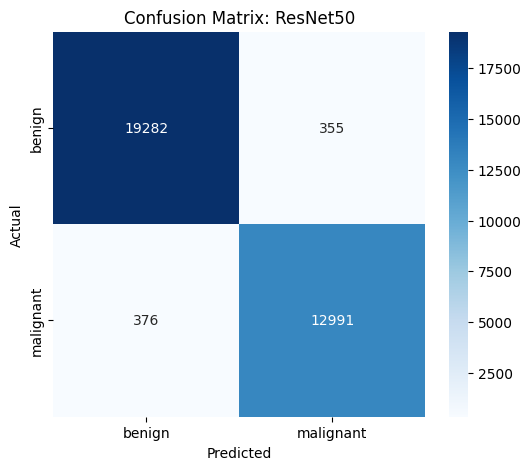


Test Accuracy: 97.79%



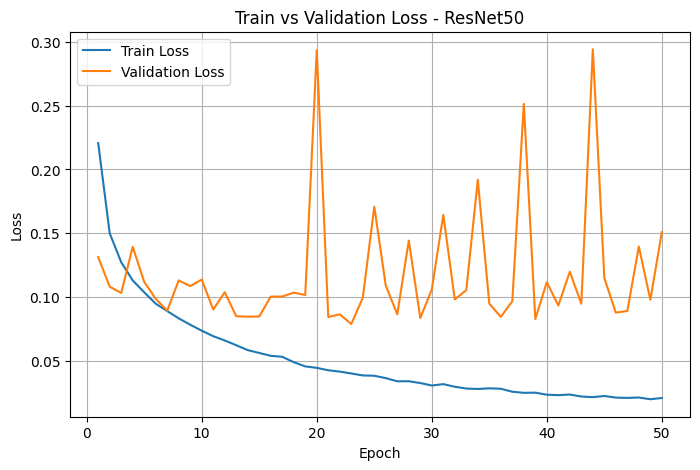

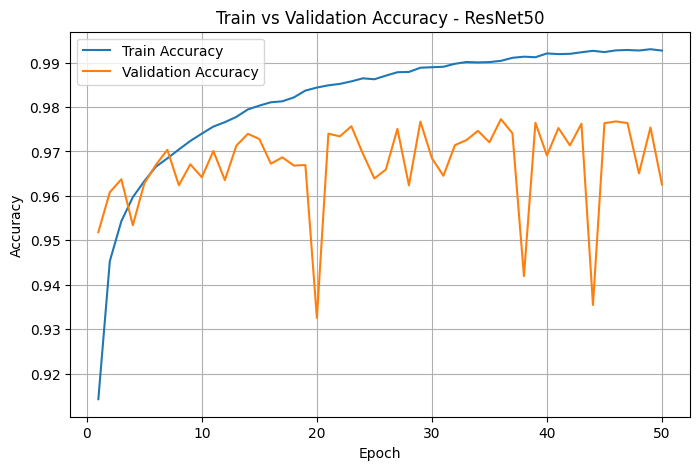

In [23]:
print("ResNet50 Model Performance:")
model_name = 'ResNet50'

resnet50_model_test_acc = evaluate_model(resnet50_model, test_loader, class_names, model_name)
print(f"\nTest Accuracy: {resnet50_model_test_acc:.2f}%\n")

plot_from_log(f'training_log_{model_name}.csv', model_name)

DenseNet121 Model Performance:

Classification Report:
               precision    recall  f1-score   support

      benign       0.98      0.98      0.98     19637
   malignant       0.97      0.98      0.97     13367

    accuracy                           0.98     33004
   macro avg       0.98      0.98      0.98     33004
weighted avg       0.98      0.98      0.98     33004



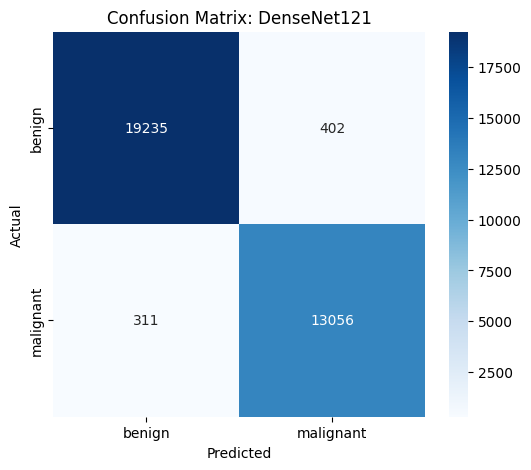


Test Accuracy: 97.84%



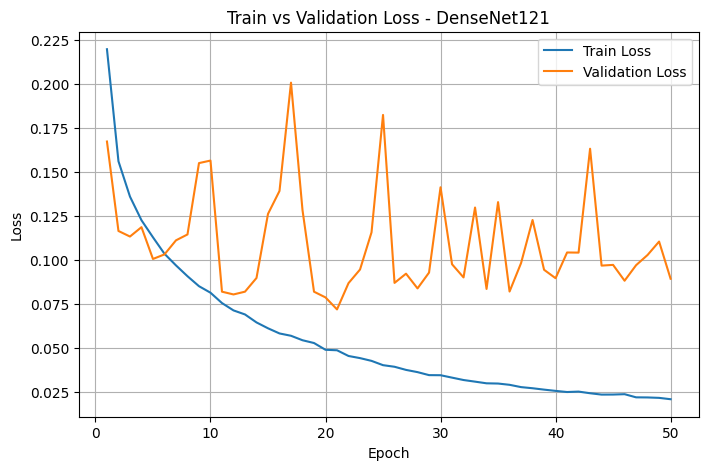

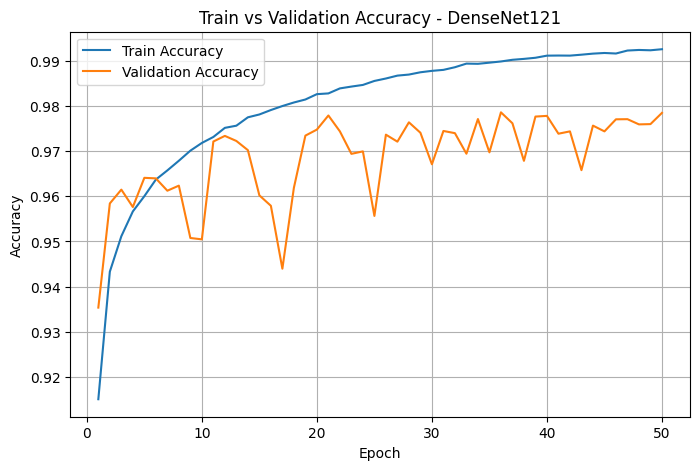

In [24]:
print("DenseNet121 Model Performance:")
model_name = 'DenseNet121'

densenet_121_model_test_acc = evaluate_model(densenet_121_model, test_loader, class_names, model_name)
print(f"\nTest Accuracy: {densenet_121_model_test_acc:.2f}%\n")

plot_from_log(f'training_log_{model_name}.csv', model_name)

VGG_16 Model Performance:

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.98      0.98     19637
   malignant       0.97      0.98      0.97     13367

    accuracy                           0.98     33004
   macro avg       0.98      0.98      0.98     33004
weighted avg       0.98      0.98      0.98     33004



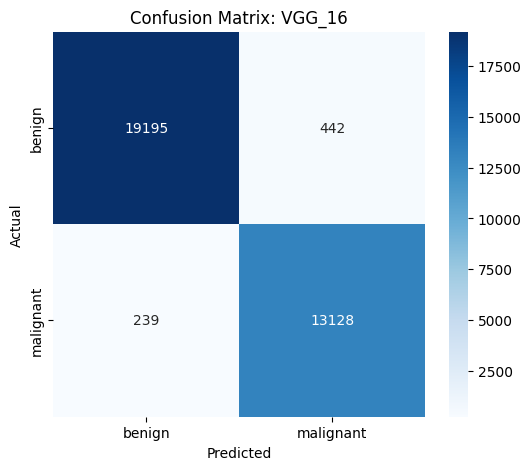


Test Accuracy: 97.94%



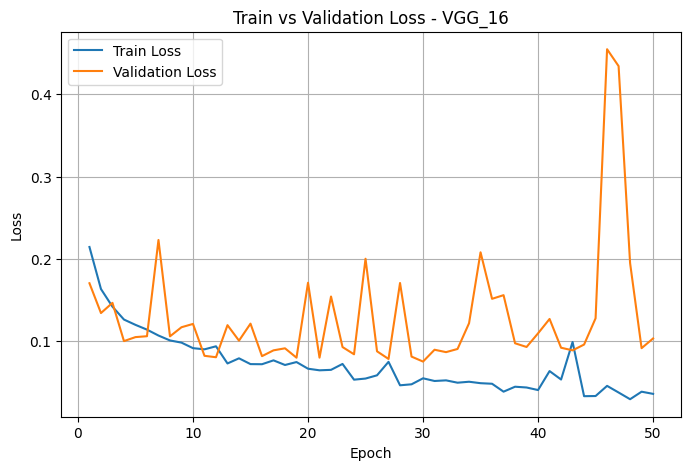

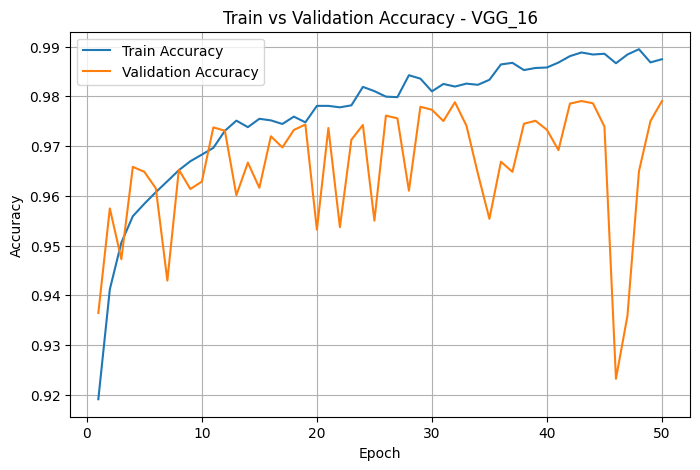

In [25]:
print("VGG_16 Model Performance:")
model_name = 'VGG_16'

vgg_16_model_test_acc = evaluate_model(vgg_16_model, test_loader, class_names, model_name)
print(f"\nTest Accuracy: {vgg_16_model_test_acc:.2f}%\n")

plot_from_log(f'training_log_{model_name}.csv', model_name)

EfficientNetV2_S Model Performance:

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.98      0.98     19637
   malignant       0.97      0.98      0.98     13367

    accuracy                           0.98     33004
   macro avg       0.98      0.98      0.98     33004
weighted avg       0.98      0.98      0.98     33004



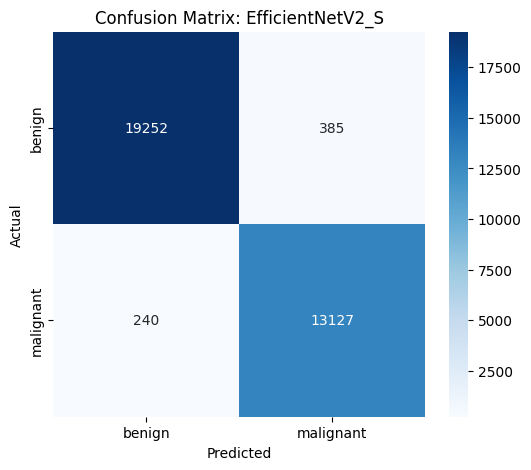


Test Accuracy: 98.11%



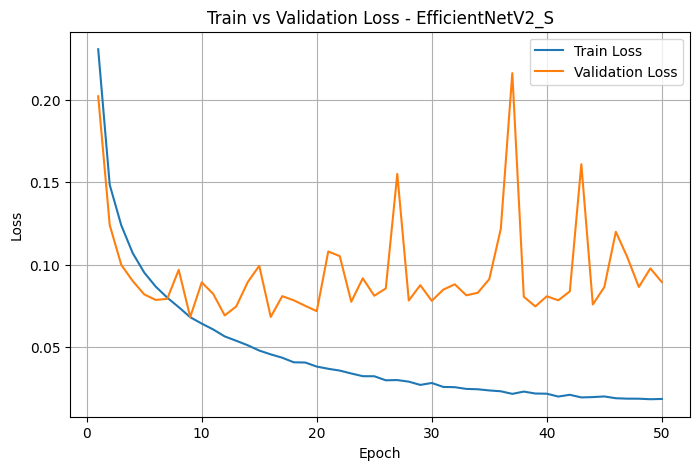

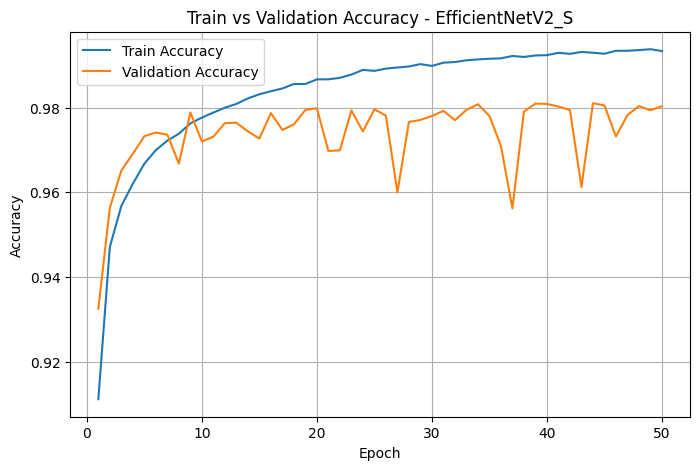

In [26]:
print("EfficientNetV2_S Model Performance:")
model_name = 'EfficientNetV2_S'

efficientnet_v2_s_model_test_acc = evaluate_model(efficientnet_v2_s_model, test_loader, class_names, model_name)
print(f"\nTest Accuracy: {efficientnet_v2_s_model_test_acc:.2f}%\n")

plot_from_log(f'training_log_{model_name}.csv', model_name)